In [1]:
import numpy as np
import pandas as pd
import scipy.io.wavfile as wavfile
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import stft
from scipy.fftpack import fft #
from scipy.signal import butter, lfilter ## used implement bandpass filter
import peakutils
import math
sns.set()

In [2]:
rate,file = wavfile.read('./../kiyoshiPRE110312_resample.wav','r')
file2 = file[60*60*rate:-10*60*rate] #removing 10 minutes from before and after

Butterworth Bandpass filter implementation:

In [3]:
def butter_filter(data, critfreq, fs, tp = 'band', order=5):
    nyq = 0.5 * fs
    critfreq = list(np.array(critfreq)/ nyq)
  #  print(critfreq)
    b, a = butter(order, critfreq, btype=tp)
    y = lfilter(b, a, data)
    return y

Creates the same intensity series discussed in the Adriano's article. In addition to this, we are able to vary the window length (in seconds) where the sum of intensities occurs and the overlap between segments (in percentage):

In [4]:
def createIntensitySeries(audioSignal, fs, windowLength = 1, overlap = 0.5):
    totalTime = len(audioSignal)//int(fs)
    intensitySeries = np.zeros(len(audioSignal)//int((fs*windowLength*(1-overlap))))
    time = np.linspace(0, totalTime,len(intensitySeries))
    squaredSignal = np.square(audioSignal)
    for i, _ in enumerate(intensitySeries):
        #print(int(fs*i*windowLength*(1-overlap)),int(fs*(i*(1-overlap) + 1)*windowLength))
        intensitySeries[i] = squaredSignal[int(fs*i*windowLength*(1-overlap)) : 
                                         int(fs*(i*(1-overlap) + 1)*windowLength)].sum()
    return time, intensitySeries

Creates another time series from the intensity series: the intervals between peaks.

In [5]:
def createIntervalSeries(intensitySeries, timeSeries, threshold, minimumDist):
    inds = peakutils.indexes(intensitySeries, thres=threshold, min_dist=minimumDist)
    #print(inds)
    #print(len(inds))
    intervalSeries = np.zeros(len(inds)-1)
    #print(len(intervalSeries))
    for j, i in enumerate(inds[1:]):
        #print(j, i, timeSeries[inds[j]] - timeSeries[inds[j-1]] )
        intervalSeries[j] = timeSeries[inds[j]] - timeSeries[inds[j-1]]
    return intervalSeries, inds

Function that performs an analysis on an audio signal. It first filters the signal, then creates the intensity series, and later performs a grid search on the peak threshold variable where I try to maximize the STII associated with the intensity series. It returns the filtered signal, the time vector, the intervals and other important arrays:

In [6]:
def fullSignalAnalysis(signal, ratesig, windowLength = 1, overlap = 0.5):
    tTime, Im = createIntensitySeries(signal, ratesig, windowLength, overlap)
    gridSearchVector = np.linspace(0.001, 0.02, 4000)
    totalSTII = np.zeros(len(gridSearchVector))
    bestinds = np.array([])
    bestSTII = 0
    bestThreshold = 0
    for i, bestThresh in enumerate(gridSearchVector):
        intervals, inds = createIntervalSeries(Im, tTime, bestThresh, 2)
        totalSTII[i] = len(intervals[(intervals > 10) & (intervals < 100)])
        if (totalSTII[i] > bestSTII):
            bestSTII = totalSTII[i]
            bestinds = inds
            bestThreshold = bestThresh
    #plt.plot(totalSTII)
    return Im, tTime, intervals, bestinds, totalSTII, bestSTII, bestThreshold

This function plots the intensity series, and marks the peaks with an x, and also saves the figure:

In [7]:
def plotIntensitySeries(Im, tTime, threshold, name):
    indexes = peakutils.indexes(Im, thres=threshold, min_dist=2)
    fig = plt.figure(figsize=(50,5))
    plt.plot(tTime/60, Im)
    plt.scatter(tTime[indexes]/60, Im[indexes] , marker='x')
    plt.show()
    fig.savefig(fname = name, dpi=500)

In [8]:
#Imfull, tTimefull, intervalfull, indsfull, STIIfull, bestSTIIfull, thresholdfull = fullSignalAnalysis(file2, rate, 80, 4000, 6)
filelow = None
filelow = butter_filter(file2, [200], rate, 'high')
filelow = butter_filter(filelow, [3900], rate, 'low')
filelow = butter_filter(filelow, [1340, 2120], rate, 'stop')
filelow = butter_filter(filelow, [300, 750], rate, 'stop')
#filelow = butter_filter(filelow, [1450,1880], rate, 'band')
#filelow = butter_filter(filelow, [1900,4000], rate, 'band')
Imlow = None
tTimelow = None
intervallow = None
indslow = None
STIIlow = None
bestSTIIlow = None
thresholdlow = None
Imlow, tTimelow, intervallow, indslow, STIIlow, bestSTIIlow, thresholdlow = fullSignalAnalysis(filelow, rate, 1, 0.5)
#Imhigh, tTimehigh, intervalhigh, indshigh, STIIhigh, bestSTIIhigh, thresholdhigh = fullSignalAnalysis(file2, rate, 2200, 4000, 6)

In [ ]:
indslow.size

In [ ]:
maxsignal = filelow.max()

In [ ]:
filelow.std()

In [ ]:
wavfile.write("segment.wav", rate, filelow[rate*(3600*5-300):rate*(3600*5+300)]/maxsignal)

In [ ]:
plt.plot(np.arange(rate*0,rate*300), filelow[rate*0:rate*300])

In [ ]:
plt.plot(np.arange(rate*9000,rate*10000), filelow[rate*9000:rate*10000])

In [ ]:
plt.plot(np.arange(rate*3600,rate*3900), filelow[rate*3600:rate*3900])

In [ ]:
rtplt = int(1/(0.25*0.5))
plt.plot(tTimelow[rtplt*3600:rtplt*3900], Imlow[rtplt*3600:rtplt*3900]/max(Imlow))

In [ ]:
plt.plot(tTimelow[2*3600:2*3900], Imlow[2*3600:2*3900])

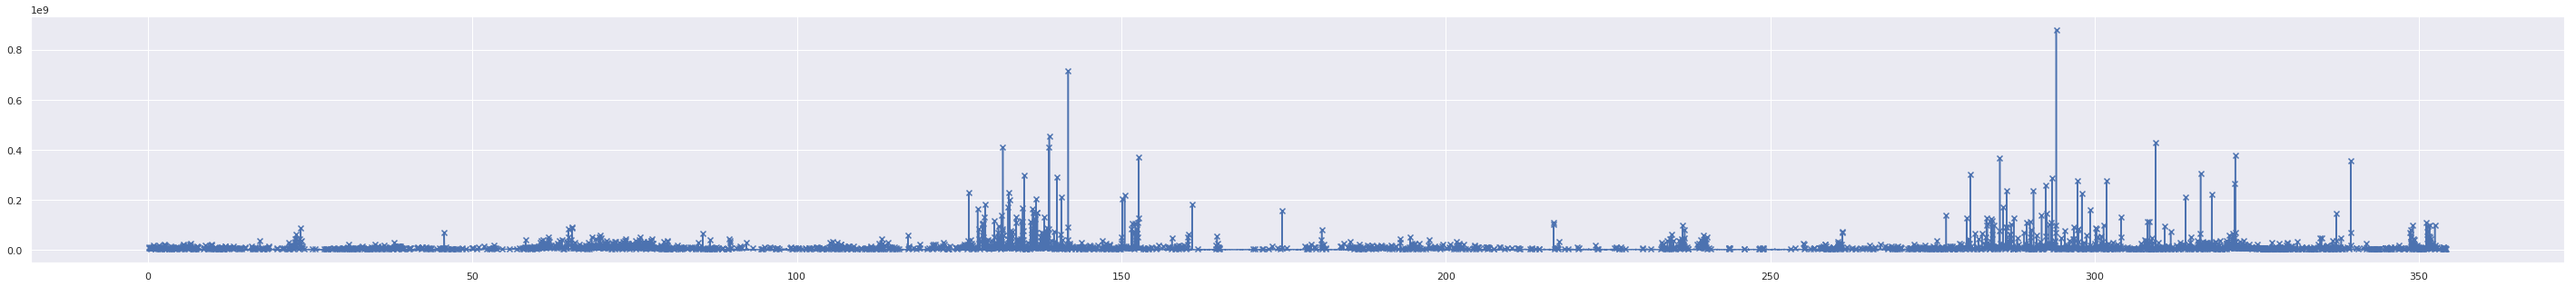

In [13]:
#plotIntensitySeries(Imfull, tTimefull, thresholdfull, "full")
plotIntensitySeries(Imlow, tTimelow, thresholdlow, "low2")
#plotIntensitySeries(Imhigh, tTimehigh, thresholdhigh, "high")

Plots the number of apnea events according to the STII index versus peak threshold choice:

In [ ]:
#plt.plot(STIIfull)
plt.plot(STIIlow)
#plt.plot(STIIhigh)
plt.show()

Code bellow is an attempt to implement the modified V-Box algorithm (Azarbazin 2011) and to check whether it works with non-tracheal audio recordings.

In [9]:
def createThetaSeries(signal, height, length, stepforward=1,  theta = 0.95, overlap = 0.5, isAudioSignal = 1):
    thetaSeries = np.zeros(int(len(signal)//(length*(1-stepforward/length))))
    for i, _ in enumerate(thetaSeries):
        box = signal[i*stepforward : i*stepforward + length]
        thetaSeries[i] = box[(box < height)&(box > -height)].size/length
    isEvent = thetaSeries < theta
    isNotEvent = thetaSeries > theta
    return thetaSeries, isEvent, isNotEvent

In [10]:
def createTimeArrayFromIsEvent(isNotEvent, arraySize, length, stepForward):
    timeArray = np.ones(arraySize)
    for m, n in zip(range(0,isNotEvent.size), range(0,arraySize,stepForward)):
        timeArray[n:n+length] = timeArray[n:n+length]*isNotEvent[m]
       # print(isNotEvent[m],m,n,int(n+1/4*length), timeArray[int(n+1/4*length):int(n+3/4*length)], timeArray[int(n+1/4*length):int(n+3/4*length)].size)
    return timeArray*(-1)+1

In [ ]:
filelow[0:440][(filelow[0:440]<10)&(filelow[0:440]>-10)].size

In [ ]:
int(len(filelow)//(int(rate//20-1)*(1-0.5)))

In [ ]:
int(rate//2-1)

In [ ]:
int(len(filelow)//(int(rate//4-1)*(1-0.5)))

In [11]:
noteventsIntstySeries = np.ones(tTimelow.size)
noteventsIntstySeries[indslow] = 0
windowlength = int(rate//2-1)
step = windowlength//2
thetas = None
events = None
notevents = None
thetas, events, notevents = createThetaSeries(filelow,35,windowlength,step)
Time = None
Time = createTimeArrayFromIsEvent(notevents, filelow.size, windowlength, step)
TimeIntensity = None
TimeIntensity = createTimeArrayFromIsEvent(noteventsIntstySeries, filelow.size, rate, int(rate//2))

In [ ]:
print(events.size,noteventsIntstySeries.size)

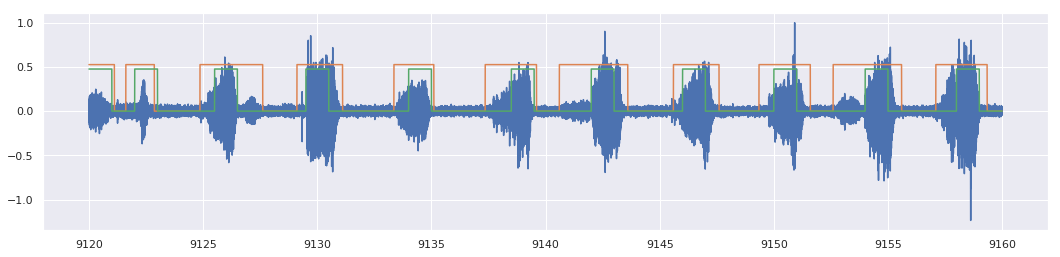

In [20]:
plt.figure(figsize=(18,4))
start = 9120
end = 9160
plt.plot(np.arange(rate*start,rate*end)/rate, filelow[rate*start:rate*end]/filelow[rate*start:rate*end].max())
plt.plot(np.arange(rate*start,rate*end)/rate, Time[rate*start:rate*end]/1.9)
plt.plot(np.arange(rate*start,rate*end)/rate, TimeIntensity[rate*start:rate*end]/2.1)

In [ ]:
events[events == 1].size/events[events == 0].size

In [ ]:
filelow.max()*0.02

In [ ]:
fig = plt.figure(figsize=(50,5))
plt.plot(notevents)
#fig.savefig(fname = 'events', dpi=500)

In [ ]:
thetas.size

In [ ]:
np.arange(0,filelow.size,220).size

In [ ]:
notevents.mean()

In [ ]:
events.size

In [ ]:
filelow.size

In [ ]:
data = np.random.random(100)*2-1

In [ ]:
a=data[25:50]
print(a)
b=(a<0.5) & (a>-0.5)
b

The code in the next two cells is broken. The gist is to analyze the effect the bandpass filters had on the snoring peak detection:

In [ ]:
print(pd.DataFrame(np.column_stack([indsfull,inds80300[:len(indsfull)]])))

In [ ]:
print(len(list(set(indsfull)-set(inds80300))))
print(len(list(set(inds80300)-set(indsfull))))
a = set(indsfull)-set(inds80300)
b = set(inds80300)-set(indsfull)
c = set(indsfull) - a

timelist = []
for i in np.sort(tTime[list(a)])/60:
    timelist += [str(int(math.modf(i)[1]))+':'+str(round(math.modf(i)[0]*6000))]
    
timelist2 = []
for i in np.sort(tTime[list(b)])/60:
    timelist2 += [str(int(math.modf(i)[1]))+':'+str(round(math.modf(i)[0]*6000))]
    
timelist3 = []
for i in np.sort(tTime[list(c)])/60:
    timelist3 += [str(int(math.modf(i)[1]))+':'+str(round(math.modf(i)[0]*6000))]
    
print(timelist,'\n\n\n',timelist2,'\n\n\n',timelist3)

Analysis of how many snoring events were found during a segment from audio. The analysis indicates that previous snoring detection algorithm was not calibrated and too many events were not detected.

In [17]:
data = pd.read_csv('KyoshiPRECSVanalise.csv',names=['time','issnore'])
data2 = data.copy()
data2['year'] = 2012
data2['month'] = 3
data2['day'] = 12
data2['hour'] = data['time']//3600
data2['minute'] = data['time']%3600//60
data2['second'] = data['time']%60
data2 = data2.set_index(pd.to_datetime(data2[['year','month','day','hour','minute','second']],infer_datetime_format=True))
data2.drop(['year','month','day','hour','minute','second','time'],axis=1, inplace=True)

/usr/local/lib/python3.5/dist-packages/pandas/core/computation/check.py:17: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


In [18]:
data2['2012-03-12 01:00:00':'2012-03-12 01:05:00']

,issnore
2012-03-12 01:01:43,0
2012-03-12 01:02:42,0
2012-03-12 01:03:57,0


Code bellow can be considered trash. :)

In [ ]:
len(segmentPOS)/ratePOS*2 #int((ratePOS*(1-0.5)))

In [ ]:
a = np.arange(10)
np.square(a)

In [ ]:
#POSfft = fft(segmentPOS - segmentPOS.mean())
#N= len(POSfft)
#freq = np.linspace(1,ratePOS*1.0/2.0,round(N*1.0/2.0))

In [ ]:
#round(len(freq))

In [ ]:
#rate

In [ ]:
#plt.plot(freq[0:30000], 2/N*np.abs(POSfft)[0:30000])

In [ ]:
sns.lineplot(freq, 2*np.abs(POSfft)[0:N//2])

In [ ]:
len(file3)/rate

In [ ]:
freq, time, audiostft = stft(file3, rate)

In [ ]:
freq2, time2, audiostft2 = stft(file4, rate)

In [ ]:
a = audiostft[:][0:500]

In [ ]:
freq

In [ ]:
time

In [ ]:
sns.heatmap(np.abs(a), vmax=6)
#plt.xticks(a[0:-1:500],[0,0.5,1.0,1.5])
#plt.colorbar()
plt.show()

In [ ]:
audiostft.shape

In [ ]:
np.abs(audiostft).std()

In [ ]:
a = list(range(0,1674))

In [ ]:
a[-1]

In [ ]:
time